In [1]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `Inference_API_KEY_8B` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.8/978.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.7 MB/s eta 0:00:00


In [21]:
!pip install opencv-python numpy ultralytics transformers pillow matplotlib


0: 480x640 1 Bus, 8 Cars, 104.3ms
Speed: 2.7ms preprocess, 104.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 93.0ms
Speed: 2.3ms preprocess, 93.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 85.1ms
Speed: 2.4ms preprocess, 85.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 83.5ms
Speed: 2.4ms preprocess, 83.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 83.8ms
Speed: 2.4ms preprocess, 83.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 84.8ms
Speed: 2.3ms preprocess, 84.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 83.3ms
Speed: 2.4ms preprocess, 83.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Bus, 8 Cars, 41.1ms
Speed: 2.4ms preprocess, 41.1ms inference, 0.9m

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Device set to use cpu
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Chatbot model error: Using `bitsandbytes` 8-bit quantization requires the latest version of bitsandbytes: `pip install -U bitsandbytes`
Ensure you are using a GPU runtime (e.g., T4 or V100) and have installed bitsandbytes.


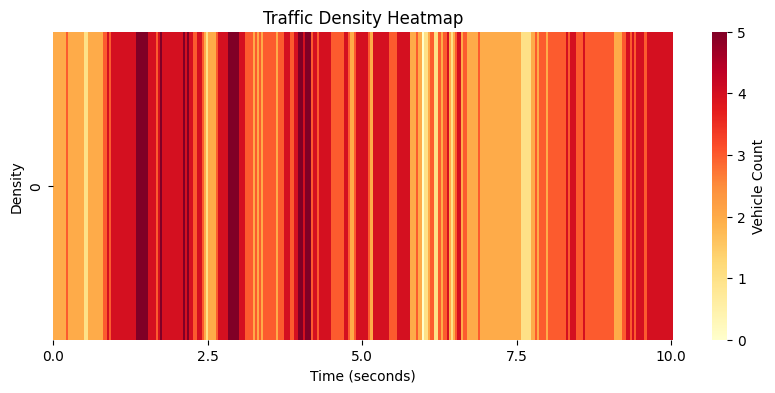

Heatmap saved as 'heatmap.png'.
Traffic data exported to 'traffic_data.csv'.


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer
from PIL import Image
from google.colab.patches import cv2_imshow
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import HTML, display
import base64
import os
import torch

# Install bitsandbytes for 8-bit quantization
try:
    import bitsandbytes
except ImportError:
    print("Installing bitsandbytes...")
    !pip install bitsandbytes
    import bitsandbytes

# Load YOLO model
model_path = r"/content/best.pt"
model = YOLO(model_path)

# Video setup
video_path = r"/content/test_10s.mp4"
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
middle_index = total_frames // 2 if total_frames > 0 else -1
fps = cap.get(cv2.CAP_PROP_FPS)
selected_frame = None
peak_frame = None
vehicle_counts = {}
track_id_to_class = {}
frame_vehicle_counts = []
frame_index = 0
max_vehicles = 0
max_frame_index = 0
emergency_alerts = []
track_positions = defaultdict(list)  # For speed estimation
average_speeds = {}
congestion_indices = []

# Process video
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (700, 500))
    results = model.track(frame, persist=True)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy().astype(int)
    track_ids = results[0].boxes.id.cpu().numpy() if results[0].boxes.id is not None else []

    # Unique vehicle counts and speed estimation
    current_frame_counts = defaultdict(int)
    for conf, cls, track_id, box in zip(confidences, classes, track_ids, boxes):
        if conf < 0.5:
            continue
        label = results[0].names[cls]
        if track_id not in track_id_to_class:
            track_id_to_class[track_id] = label
            vehicle_counts[label] = vehicle_counts.get(label, 0) + 1
        current_frame_counts[label] += 1
        # Track position for speed (center of bounding box)
        center_x = (box[0] + box[2]) / 2
        center_y = (box[1] + box[3]) / 2
        track_positions[track_id].append((frame_index, center_x, center_y))

    frame_vehicle_counts.append(dict(current_frame_counts))

    # Emergency vehicle alerts
    if current_frame_counts.get("Ambulance", 0) > 1:
        emergency_alerts.append(f"High ambulance activity at {frame_index/fps:.2f}s: {current_frame_counts['Ambulance']} ambulances")

    # Congestion index
    total_in_frame = sum(current_frame_counts.values())
    congestion_index = total_in_frame / 5.0  # Normalize (5 vehicles = index 1.0)
    congestion_indices.append(congestion_index)
    if total_in_frame > max_vehicles:
        max_vehicles = total_in_frame
        max_frame_index = frame_index
        peak_frame = results[0].plot()

    # Save middle frame
    if frame_index == middle_index:
        selected_frame = results[0].plot()

    frame_index += 1

cap.release()
cv2.destroyAllWindows()

# Calculate average speeds
for track_id, positions in track_positions.items():
    label = track_id_to_class[track_id]
    if len(positions) < 2:
        continue
    total_speed = 0
    count = 0
    for i in range(1, len(positions)):
        frame_diff = positions[i][0] - positions[i-1][0]
        if frame_diff == 0:
            continue
        dx = positions[i][1] - positions[i-1][1]
        dy = positions[i][2] - positions[i-1][2]
        distance = np.sqrt(dx**2 + dy**2)
        time = frame_diff / fps
        speed = distance / time  # Pixels per second
        total_speed += speed
        count += 1
    if count > 0:
        avg_speed = total_speed / count
        average_speeds[label] = average_speeds.get(label, 0) + avg_speed
        average_speeds[f"{label}_count"] = average_speeds.get(f"{label}_count", 0) + 1

for label in vehicle_counts.keys():
    count_key = f"{label}_count"
    if count_key in average_speeds:
        average_speeds[label] = average_speeds[label] / average_speeds[count_key]
        del average_speeds[count_key]

# Save annotated frames
if selected_frame is not None:
    cv2.imwrite("middle_frame.jpg", selected_frame)
    print("Middle frame saved as 'middle_frame.jpg'.")
else:
    print("Warning: Middle frame not saved.")
if peak_frame is not None:
    cv2.imwrite("peak_frame.jpg", peak_frame)
    print("Peak frame saved as 'peak_frame.jpg'.")
else:
    print("Warning: Peak frame not saved.")

# Convert middle frame to PIL for report generation
if selected_frame is not None:
    selected_frame_rgb = cv2.cvtColor(selected_frame, cv2.COLOR_BGR2RGB)
    selected_frame_pil = Image.fromarray(selected_frame_rgb)
else:
    print("Warning: No middle frame selected for PIL conversion.")
    selected_frame_pil = None

# Load report pipeline
try:
    pipe = pipeline("image-text-to-text", model="meta-llama/Llama-3.2-11B-Vision")
except Exception as e:
    print(f"Vision model error: {e}")
    try:
        pipe = pipeline("text2text-generation", model="meta-llama/Llama-3.2-11B")
    except Exception as e:
        print(f"Llama error: {e}")
        pipe = None

# Load chatbot model (Flan-T5-Large with 8-bit quantization)
try:
    tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
    model = T5ForConditionalGeneration.from_pretrained(
        "google/flan-t5-large",
        device_map="auto",
        load_in_8bit=True
    )
    chatbot = pipeline(
        "text2text-generation",
        model=model,
        tokenizer=tokenizer,
        num_beams=4,
        early_stopping=True,
        device_map="auto"
    )
    print("Flan-T5-Large loaded for chatbot.")
except Exception as e:
    print(f"Chatbot model error: {e}")
    print("Ensure you are using a GPU runtime (e.g., T4 or V100) and have installed bitsandbytes.")
    chatbot = None

# Calculate averages and congestion
average_counts = {}
for vtype in vehicle_counts.keys():
    total = sum(frame_counts.get(vtype, 0) for frame_counts in frame_vehicle_counts)
    average_counts[vtype] = total / len(frame_vehicle_counts) if frame_vehicle_counts else 0
max_time_sec = max_frame_index / fps if fps > 0 else 0
average_congestion = np.mean(congestion_indices) if congestion_indices else 0

# Generate traffic density heatmap
times = [i / fps for i in range(len(frame_vehicle_counts))]
total_vehicles_per_frame = [sum(frame_counts.values()) for frame_counts in frame_vehicle_counts]
plt.figure(figsize=(10, 4))
sns.heatmap([total_vehicles_per_frame], cmap="YlOrRd", xticklabels=50, cbar_kws={'label': 'Vehicle Count'})
plt.xlabel("Time (seconds)")
plt.ylabel("Density")
plt.title("Traffic Density Heatmap")
plt.xticks(ticks=np.linspace(0, len(times)-1, 5), labels=[f"{t:.1f}" for t in np.linspace(0, max(times), 5)])
plt.savefig("heatmap.png")
plt.show()
print("Heatmap saved as 'heatmap.png'.")

# Export to CSV
csv_data = {
    "Frame": list(range(len(frame_vehicle_counts))),
    "Time (s)": times,
    "Total Vehicles": total_vehicles_per_frame,
    "Congestion Index": congestion_indices
}
for vtype in vehicle_counts.keys():
    csv_data[vtype] = [frame_counts.get(vtype, 0) for frame_counts in frame_vehicle_counts]
df = pd.DataFrame(csv_data)
df.to_csv("traffic_data.csv", index=False)
print("Traffic data exported to 'traffic_data.csv'.")

# Generate text report
report_prompt = (
    f"Vehicle Detection Report:\n"
    f"Unique vehicle counts across all frames:\n"
)
for vtype, count in vehicle_counts.items():
    report_prompt += f"{vtype}: {count}\n"
report_prompt += "Additional Insights:\n"
report_prompt += "Average vehicles per frame:\n"
for vtype, avg in average_counts.items():
    report_prompt += f"{vtype}: {avg:.2f}\n"
report_prompt += f"Average speeds (pixels/s):\n"
for vtype, speed in average_speeds.items():
    report_prompt += f"{vtype}: {speed:.2f}\n"
report_prompt += f"Peak traffic at {max_time_sec:.2f} seconds with {max_vehicles} vehicles.\n"
report_prompt += f"Average congestion index: {average_congestion:.2f} (0=low, 1=moderate, >2=high).\n"
if emergency_alerts:
    report_prompt += "Emergency Alerts:\n" + "\n".join(emergency_alerts) + "\n"
if frame_vehicle_counts and middle_index < len(frame_vehicle_counts):
    selected_counts = frame_vehicle_counts[middle_index]
    report_prompt += "Selected middle frame shows:\n"
    for vtype, count in selected_counts.items():
        report_prompt += f"{vtype}: {count}\n"
report_prompt += "Generate a detailed summary based on this data and describe the scene in the selected frame."

try:
    if selected_frame_pil and pipe and "image-text-to-text" in str(pipe):
        result = pipe(image=selected_frame_pil, text=report_prompt, max_new_tokens=300)
        report_text = result[0]['generated_text']
    elif pipe:
        result = pipe(text=report_prompt, max_new_tokens=300)
        report_text = result[0]['generated_text']
    else:
        report_text = "Report failed. Counts:\n" + "\n".join([f"{v}: {c}" for v, c in vehicle_counts.items()])
except Exception as e:
    print(f"Report error: {e}")
    report_text = "Report failed. Counts:\n" + "\n".join([f"{v}: {c}" for v, c in vehicle_counts.items()])

print("\n--- Generated Report ---\n")
print(report_text)

# Visualization Dashboard
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
ax1.plot(times, total_vehicles_per_frame, color='blue')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Total Vehicles')
ax1.set_title('Total Vehicles Over Time')
ax1.grid(True)

vehicle_types = list(vehicle_counts.keys())
for vtype in vehicle_types:
    counts = [frame_counts.get(vtype, 0) for frame_counts in frame_vehicle_counts]
    ax2.plot(times, counts, label=vtype)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Vehicle Count')
ax2.set_title('Vehicle Counts by Type Over Time')
ax2.legend()
ax2.grid(True)

ax3.bar(vehicle_types, [vehicle_counts[vtype] for vtype in vehicle_types], color='green')
ax3.set_xlabel('Vehicle Type')
ax3.set_ylabel('Unique Count')
ax3.set_title('Unique Vehicle Counts')
ax3.grid(True, axis='y')

plt.tight_layout()
plt.savefig("dashboard.png")
plt.show()
print("Dashboard saved as 'dashboard.png'.")

# Encode images as base64
def encode_image_to_base64(image_path):
    if os.path.exists(image_path):
        with open(image_path, "rb") as image_file:
            encoded = base64.b64encode(image_file.read()).decode('utf-8')
            print(f"Successfully encoded {image_path} to base64.")
            return encoded
    print(f"Warning: {image_path} not found for base64 encoding.")
    return None

dashboard_b64 = encode_image_to_base64("dashboard.png")
middle_frame_b64 = encode_image_to_base64("middle_frame.jpg")
peak_frame_b64 = encode_image_to_base64("peak_frame.jpg")
heatmap_b64 = encode_image_to_base64("heatmap.png")

# Generate enhanced HTML report
report_text_html = report_text.replace('\n', '<br>')
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Vehicle Detection Report</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; }}
        h1, h2 {{ color: #333; cursor: pointer; }}
        table {{ border-collapse: collapse; width: 50%; margin: 20px 0; }}
        th, td {{ border: 1px solid #ccc; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
        img {{ max-width: 100%; height: auto; margin: 10px 0; }}
        .section {{ margin-bottom: 20px; }}
        .collapsible {{ display: none; }}
        .collapsible.show {{ display: block; }}
    </style>
    <script>
        function toggleSection(id) {{
            var content = document.getElementById(id);
            content.classList.toggle('show');
        }}
    </script>
</head>
<body>
    <h1>Vehicle Detection Report</h1>
    <div class="section">
        <h2 onclick="toggleSection('summary')">Summary</h2>
        <div id="summary" class="collapsible show">
            <p>{report_text_html}</p>
        </div>
    </div>
    <div class="section">
        <h2 onclick="toggleSection('stats')">Vehicle Statistics</h2>
        <div id="stats" class="collapsible">
            <table>
                <tr><th>Vehicle Type</th><th>Unique Count</th><th>Average per Frame</th><th>Middle Frame Count</th><th>Average Speed (pixels/s)</th></tr>
"""
for vtype in vehicle_counts.keys():
    unique_count = vehicle_counts.get(vtype, 0)
    avg_count = average_counts.get(vtype, 0)
    middle_count = frame_vehicle_counts[middle_index].get(vtype, 0) if middle_index < len(frame_vehicle_counts) else 0
    speed = average_speeds.get(vtype, 0)
    html_content += f"<tr><td>{vtype}</td><td>{unique_count}</td><td>{avg_count:.2f}</td><td>{middle_count}</td><td>{speed:.2f}</td></tr>"
html_content += "</table></div></div>"
html_content += f"""
    <div class="section">
        <h2 onclick="toggleSection('insights')">Key Insights</h2>
        <div id="insights" class="collapsible">
            <p>Peak traffic occurred at {max_time_sec:.2f} seconds with {max_vehicles} vehicles.</p>
            <p>Average congestion index: {average_congestion:.2f} (0=low, 1=moderate, >2=high).</p>
"""
if emergency_alerts:
    html_content += "<p>Emergency Alerts:</p><ul>" + "".join([f"<li>{alert}</li>" for alert in emergency_alerts]) + "</ul>"
html_content += "</div></div>"
html_content += f"""
    <div class="section">
        <h2 onclick="toggleSection('visuals')">Visualizations</h2>
        <div id="visuals" class="collapsible">
"""
if dashboard_b64:
    html_content += f'<img src="data:image/png;base64,{dashboard_b64}" alt="Visualization Dashboard">'
else:
    html_content += "<p>Dashboard image not available.</p>"
if heatmap_b64:
    html_content += f'<img src="data:image/png;base64,{heatmap_b64}" alt="Traffic Density Heatmap">'
else:
    html_content += "<p>Heatmap image not available.</p>"
if middle_frame_b64:
    html_content += f'<img src="data:image/jpeg;base64,{middle_frame_b64}" alt="Middle Frame">'
else:
    html_content += "<p>Middle frame image not available.</p>"
if peak_frame_b64:
    html_content += f'<img src="data:image/jpeg;base64,{peak_frame_b64}" alt="Peak Traffic Frame">'
else:
    html_content += "<p>Peak frame image not available.</p>"
html_content += """
        </div>
    </div>
    <div class="section">
        <p><strong>Note:</strong> This is an HTML report. Do not copy-paste into a Python cell, as it will cause a syntax error. View it here or open 'report.html' in a browser.</p>
    </div>
</body>
</html>
"""
with open("report.html", "w") as f:
    f.write(html_content)
print("\nHTML report generated as 'report.html' and displayed below.")
print("Note: If the report doesn't display, open 'report.html' in a browser or check for errors above.")

# Display HTML report in Colab
try:
    display(HTML(html_content))
except Exception as e:
    print(f"Error displaying HTML: {e}")
    print("Please open 'report.html' in a browser to view the report.")

# Create optimized context for chatbot
context = (
    f"Video Analysis: {total_frames} frames, {(total_frames/fps):.2f}s, {fps:.2f} FPS.\n"
    f"Unique vehicles: {', '.join([f'{v}: {c}' for v, c in vehicle_counts.items()])} (total: {sum(vehicle_counts.values())}).\n"
    f"Average per frame: {', '.join([f'{v}: {c:.2f}' for v, c in average_counts.items()])}.\n"
    f"Average speeds (pixels/s): {', '.join([f'{v}: {s:.2f}' for v, s in average_speeds.items()])}.\n"
    f"Peak traffic: {max_vehicles} vehicles at {max_time_sec:.2f}s.\n"
    f"Middle frame ({middle_index/fps:.2f}s): {', '.join([f'{v}: {c}' for v, c in frame_vehicle_counts[middle_index].items()]) if middle_index < len(frame_vehicle_counts) else 'no vehicles'}.\n"
    f"Vehicle types: {', '.join(vehicle_counts.keys())}.\n"
    f"Traffic: {'Heavy' if sum(vehicle_counts.values()) > 30 else 'Moderate' if sum(vehicle_counts.values()) > 15 else 'Light'}.\n"
    f"Congestion index: {average_congestion:.2f} (0=low, 1=moderate, >2=high).\n"
)
if emergency_alerts:
    context += f"Emergency alerts: {'; '.join(emergency_alerts)}.\n"

# Updated answer_question function
def answer_question(question, vehicle_counts, frame_vehicle_counts, fps, total_frames, average_counts, max_time_sec, max_vehicles, context, chatbot, average_speeds, congestion_indices, emergency_alerts):
    question = question.lower().strip()
    if not question:
        return "Please ask a valid question."

    # Rule-based answers
    time_match = re.search(r"at (\d+) seconds", question)
    if time_match:
        time_sec = int(time_match.group(1))
        if time_sec * fps >= total_frames:
            return f"Time {time_sec} seconds exceeds video duration ({total_frames/fps:.2f}s)."
        frame_index = min(int(time_sec * fps), total_frames - 1)
        frame_counts = frame_vehicle_counts[frame_index]
        for vtype in vehicle_counts.keys():
            if vtype.lower() in question:
                count = frame_counts.get(vtype, 0)
                return f"At {time_sec} seconds, there were {count} {vtype}(s)."
        if "traffic" in question or "how many" in question:
            counts_str = ", ".join([f"{count} {vtype}(s)" for vtype, count in frame_counts.items()])
            return f"At {time_sec} seconds: {counts_str or 'no vehicles'}."
        total = sum(frame_counts.values())
        return f"At {time_sec} seconds, there were {total} vehicles."

    if "peak" in question:
        return f"Peak traffic was at {max_time_sec:.2f} seconds with {max_vehicles} vehicles."

    if "average" in question and "speed" in question:
        for vtype in vehicle_counts.keys():
            if vtype.lower() in question:
                speed = average_speeds.get(vtype, 0)
                return f"Average speed of {vtype}s: {speed:.2f} pixels/s."
        speeds_str = ", ".join([f"{vtype}: {speed:.2f} pixels/s" for vtype, speed in average_speeds.items()])
        return f"Average speeds: {speeds_str or 'none'}."

    if "average" in question:
        for vtype in vehicle_counts.keys():
            if vtype.lower() in question:
                avg = average_counts.get(vtype, 0)
                return f"Average {vtype}s per frame: {avg:.2f}."
        averages_str = ", ".join([f"{vtype}: {avg:.2f}" for vtype, avg in average_counts.items()])
        return f"Average vehicles per frame: {averages_str or 'none'}."

    if re.search(r"how many (total |)vehicles", question) or "total number" in question:
        total = sum(vehicle_counts.values())
        return f"Total unique vehicles: {total}."

    for vtype, count in vehicle_counts.items():
        type_lower = vtype.lower()
        if any(phrase in question for phrase in [f"how many {type_lower}", f"number of {type_lower}", f"how many {type_lower}s", f"{type_lower}s in the video", f"{type_lower} in the video"]):
            return f"Unique {vtype}(s) detected: {count}."

    if "most common" in question or "most frequent" in question:
        if vehicle_counts:
            most_common = max(vehicle_counts.items(), key=lambda x: x[1])
            return f"Most common vehicle: {most_common[0]} ({most_common[1]} instances)."
        return "No vehicles detected."

    if "what types" in question or "vehicle types" in question or "which vehicles" in question:
        if vehicle_counts:
            types = list(vehicle_counts.keys())
            types_str = ", ".join(types[:-1]) + " and " + types[-1] if len(types) > 1 else types[0]
            return f"Vehicle types: {types_str}."
        return "No vehicles detected."

    if "traffic" in question and ("condition" in question or "overall" in question):
        total = sum(vehicle_counts.values())
        condition = "heavy" if total > 30 else "moderate" if total > 15 else "light"
        return f"Traffic was {condition} with {total} unique vehicles."

    if "congestion" in question or "congested" in question:
        avg_congestion = np.mean(congestion_indices) if congestion_indices else 0
        level = "high" if avg_congestion > 2 else "moderate" if avg_congestion > 1 else "low"
        return f"Average congestion index: {avg_congestion:.2f} ({level})."

    if "emergency" in question or "alerts" in question or "ambulance activity" in question:
        if emergency_alerts:
            return f"Emergency alerts: {'; '.join(emergency_alerts)}."
        return "No emergency alerts detected."

    # Chatbot for open-ended and hypothetical questions
    if chatbot:
        try:
            is_exploratory = any(kw in question for kw in ["describe", "tell me", "what can you say", "interesting", "summarize", "activity", "happening"])
            is_hypothetical = any(kw in question for kw in ["would", "might", "could", "help"])

            if is_exploratory:
                prompt = (
                    f"{context}\n"
                    f"Instruction: Describe the traffic in detail, including vehicle types, counts, speeds, or trends. Start with 'The video shows...'.\n"
                    f"Example:\n"
                    f"Q: What was happening in the middle?\n"
                    f"A: The video shows 3 cars and 1 ambulance in the middle frame at 5s, moving at 50 pixels/s, with moderate traffic.\n"
                    f"Question: {question}\nAnswer:"
                )
            elif is_hypothetical:
                prompt = (
                    f"{context}\n"
                    f"Instruction: Reason about the traffic data to answer speculatively, discussing causes, impacts, or applications. Start with 'Based on the data...'.\n"
                    f"Example:\n"
                    f"Q: What might cause a peak?\n"
                    f"A: Based on the data, a peak of 4 vehicles at 3.2s could be due to a traffic signal.\n"
                    f"Question: {question}\nAnswer:"
                )
            else:
                prompt = (
                    f"{context}\n"
                    f"Instruction: Answer concisely using the data, focusing on counts, peak, speeds, or congestion.\n"
                    f"Example:\n"
                    f"Q: What was the traffic like?\n"
                    f"A: The traffic was moderate with 9 vehicles, peaking at 4 vehicles at 3.2s, congestion index 0.8.\n"
                    f"Question: {question}\nAnswer:"
                )

            response = chatbot(prompt, max_length=80, num_return_sequences=1)[0]['generated_text'].strip()
            if response and len(response) > 10 and not response.startswith(("Instruction:", "Example:", "Question:")):
                sentences = re.split(r'(?<=[.!?])\s+', response)
                return " ".join(sentences[:min(3, len(sentences))]).strip()
            else:
                simplified_prompt = f"{context}\nQuestion: {question}\nAnswer concisely:"
                response = chatbot(simplified_prompt, max_length=80, num_return_sequences=1)[0]['generated_text'].strip()
                if response and len(response) > 10:
                    sentences = re.split(r'(?<=[.!?])\s+', response)
                    return " ".join(sentences[:min(3, len(sentences))]).strip()
                print(f"Debug: Invalid chatbot response for: {question} (response: {response})")
                return f"Please rephrase your question. Summary: {', '.join([f'{v}: {c}' for v, c in vehicle_counts.items()])}."
        except Exception as e:
            print(f"Debug: Chatbot error for '{question}': {e}")
            return f"Error processing question. Summary: {', '.join([f'{v}: {c}' for v, c in vehicle_counts.items()])}."
    return f"No chatbot available. Summary: {', '.join([f'{v}: {c}' for v, c in vehicle_counts.items()])}."

# Dynamic chat suggestions
suggestions = [
    "How many cars were detected in total?",
    "How many ambulances were in the video?",
    "How many vehicles at 5 seconds?",
    "What was the peak traffic time?",
    "What types of vehicles were detected?",
    "Tell me about the vehicles in the video.",
    "What can you say about the traffic flow?",
    "What was happening in the middle of the video?",
    "Was there anything interesting in the video?",
    "What might cause a peak like this?",
    "How could this data help traffic management?",
    "What was the average speed of cars?",
    "How congested was the traffic?"
]
if emergency_alerts:
    suggestions.append("When were ambulances most active?")

# Chat loop with guidance
print("\nVideo processing complete. Ask any question about the video (type 'exit' to quit).")
print("Suggested questions:")
for i, suggestion in enumerate(suggestions, 1):
    print(f"{i}. {suggestion}")
while True:
    user_query = input("Ask a question: ")
    if user_query.lower().strip() == "exit":
        print("Goodbye.")
        break
    response = answer_question(user_query, vehicle_counts, frame_vehicle_counts, fps, total_frames, average_counts, max_time_sec, max_vehicles, context, chatbot, average_speeds, congestion_indices, emergency_alerts)
    print("\nAnswer:")
    print(response)
    print()